In [2]:
%matplotlib inline

/home/yuanpu/local/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# The following is for cell detection test.

In [3]:
# -*- coding: utf-8 -*-

# -*- coding: utf-8 -*-
import sys
import os
os.environ['KERAS_BACKEND'] = 'theano'
#os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['THEANO_FLAGS'] = 'device=gpu3,optimizer=fast_run,force_device=True, allow_gc=True'
CopyRoot  = os.path.join('..','..','..','..')
projroot = os.path.join('..','..')
#dataroot = os.path.join(CopyRoot,'WorkStation','MIA_stru', 'Data')
dataroot = os.path.join(projroot, 'Data')

test_type = 'fcn'
kerasversion = 'keras-1'
sys.path.insert(0, os.path.join(CopyRoot, 'Code', kerasversion))
sys.path.insert(0, os.path.join(CopyRoot, 'Code', kerasversion,'keras'))
sys.path.insert(0, os.path.join(CopyRoot, 'Code', kerasversion,'keras','layers'))
sys.path.insert(0, '..')
sys.path.insert(0,  os.path.join('..', 'proj_utils') )

from local_utils import *
import cv2

from testingclass import runtestImg
import warnings
import time
warnings.filterwarnings("ignore")

#from post_process import watershed_marker, label2rgb, overal_cell_watershed
from proj_utils.keras_utils import elu

det_dataset = 'Com_Det'    
det_modelname = 'deep_det_fcn'

seg_dataset = 'Com_Seg'    
seg_modelname = 'cell_seg_fcn'

from kerasOneModel import buildCellModel as build_det_model
from kerasOneModel import buildCellSegModel as build_seg_model
#modelname = 'deep_det_cell_seg_model'
#from kerasOneModel import buildCellSegModel as build_det_model
activ = elu(alpha=1.0) 
det_last_activ = 'relu'
seg_last_activ = 'sigmoid'

def writeResults(coordinates, filepath):
    N = coordinates.shape[0]
    with open(filepath, 'w') as rf:
        rf.write(str(N) + '\n')
        rf.write(str(N) + '\n') 
        rf.write(str(N) + '\n') 
        for line in coordinates:
            rf.write(" ".join(map(str, line)) + '\n' )            
    rf.close()

def load_weights(strumodel =None, modelbasefolder = None, dataset = 'Mixture', modelname='dilated_residual_fcn'):
    weightspath = os.path.join(modelbasefolder, dataset,modelname, 'weights.h5')
    strumodel.load_weights(weightspath)
    return strumodel

def prob_fn(imgfile, model=None, windowsize = 1000, batch_size = 3, linewidth = 7,color=[0,1,0],classparams = None):
    #this function is for web interface 
    if classparams is None:
        classparams = {'test_type':'fcn'}
    
    tester = runtestImg(classparams)
    if isinstance(imgfile, basestring):
        orgImg = imread(imgfile)
    else:
        orgImg = imgfile
    TestingFunc = tester.shortCut_FCN
    mask = TestingFunc(orgImg.copy(), model = model,windowsize = windowsize, batch_size = batch_size, linewidth = linewidth, color= color)
    #mask = tester.printMask(img= orgImg.copy(), mask=mask)
    return mask

def seg_fn(seg_prob, coordinates, thresh = 0.5):
    marker_map = np.zeros_like(seg_prob).astype(np.uint8)
    marker_map[coordinates[:, 0], coordinates[:, 1]] = 1
    #imshow(marker_map)
    #se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
    #marker_map = cv2.dilate(marker_map,se)
    
    #label_img = overal_cell_watershed(seg_prob, marker_map, thresh = thresh)
    label_img = watershed_marker(seg_prob, marker_map, thresh = thresh)
    return label_img
    
def det_fn(imgfile, model=None, windowsize = 1000, batch_size = 3,min_len=7, linewidth = 7,color=[0,1,0]):
    if isinstance(imgfile, basestring):
       orgImg = imread(imgfile)
    else:
       orgImg = imgfile
    coordinates = detection_coord(orgImg, model=model, windowsize = windowsize, batch_size = batch_size,
                                  min_len=min_len, linewidth = linewidth, color= color)
    overlaied_img = tester.printCoord(Img=orgImg, coordinates=coordinates, savepath=None, linewidth = 7,color=[0,1,0])
    return overlaied_img, coordinates
    
def detection_coord(imgfile, model=None, windowsize = 1000, batch_size = 3,min_len=7, linewidth = 7,color=[0,1,0]):
    #this function is for web interface  
    classparams = {'test_type':test_type}
    
    tester = runtestImg(classparams)
    
    if isinstance(imgfile, basestring):
       orgImg = imread(imgfile)
    else:
       orgImg = imgfile
    TestingFunc = tester.get_coordinate
    coordinates = TestingFunc(orgImg.copy(), model = model,windowsize = windowsize, min_len= min_len, 
                              batch_size = batch_size, linewidth = linewidth, color= color)
    return coordinates

    
def setpath(KerasRoot):
    sys.path.insert(0, os.path.join(KerasRoot))
    sys.path.insert(0, os.path.join(KerasRoot,'keras'))
    sys.path.insert(0, os.path.join(KerasRoot,'keras','layers'))
        
#if __name__ == "__main__":
    # the following are just for default testing    
modelbasefolder = os.path.join(projroot, 'Data', 'Model')        
if len(sys.argv) >= 4:       
   imgfile, filepath, KerasRoot, modelbasefolder = sys.argv[1], sys.argv[2], sys.argv[3], sys.argv[4]   
   setpath(KerasRoot)

det_model = build_det_model(img_channels = 3, activ=activ, last_activ = det_last_activ)   
det_model = load_weights(strumodel = det_model,modelbasefolder = modelbasefolder, modelname = det_modelname, dataset = det_dataset)

seg_model = build_seg_model(img_channels = 3, activ=activ, last_activ = seg_last_activ)   
seg_model = load_weights(strumodel = seg_model,modelbasefolder = modelbasefolder, modelname = seg_modelname, dataset = seg_dataset)

print "Finihsed compilation!"
    

Using Theano backend.
Using gpu device 3: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


Finihsed compilation!


In [94]:
  #imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_ki67','R1C2__01_1_c1.png')   
imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_lung','85-6798-1.tif')

imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_lung','85-7696-1.tif')
imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_lung','85-7697-1.tif')
imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_lung','85-7698-1.tif')
imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_lung','85-7710-1.tif')

imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_ki67','R6C6__01_1_c11.png')       
imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_ki67','R2C7__01_1_c5.png')       
imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_ki67','R1C4__01_1_c2.png')       
#imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_ki67','R2C10__01_1_c4.png') 
#imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_ki67','largeTest_small1.png') 

#imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_breast','TCGA-A2-A0CQ100949_22824.png') 
#imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_breast','TCGA-A2-A0YK22243_20922.png') 
#imgfile = os.path.join(projroot, 'Data', 'imgsForDemo','imgs_breast','TCGA-A2-A0CQ100949_22824.png') 


classparams = {'test_type':test_type}
tester = runtestImg(classparams)
TestingFunc = tester.get_coordinate

#coordinates = TestingFunc(imgfile, model = strumodel)
start = time.time()
img = imread(imgfile)
det_masked,coordinates = det_fn(img, model = det_model)
print time.time() - start    

#imshow(det_masked)

seg_map =  prob_fn(img, model = seg_model)
#imshow(seg_map)
print 'finished computation'



1.6572971344
finished computation


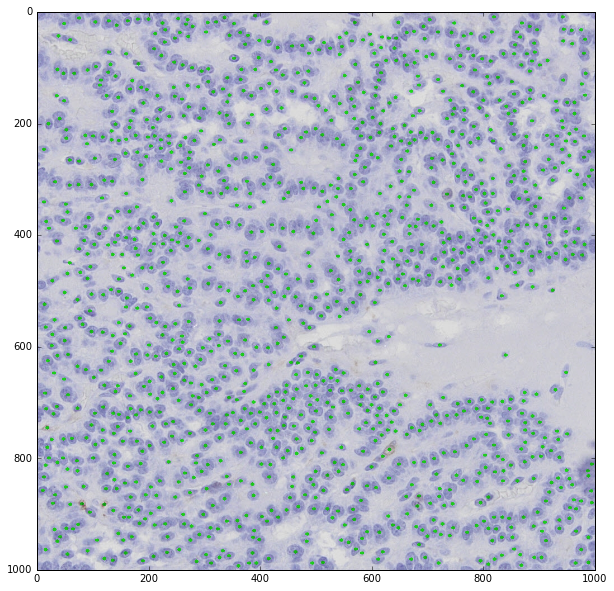

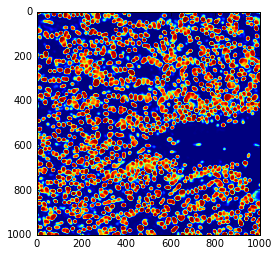

In [81]:
imshow(det_masked, (10,10))
imshow(seg_map)

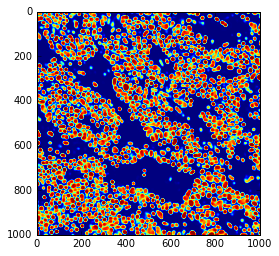

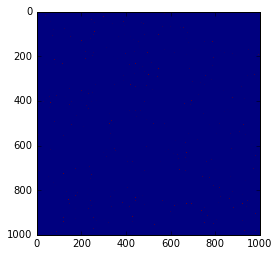

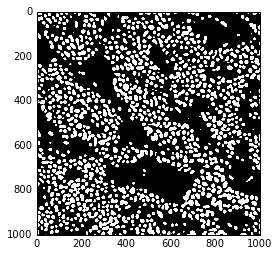

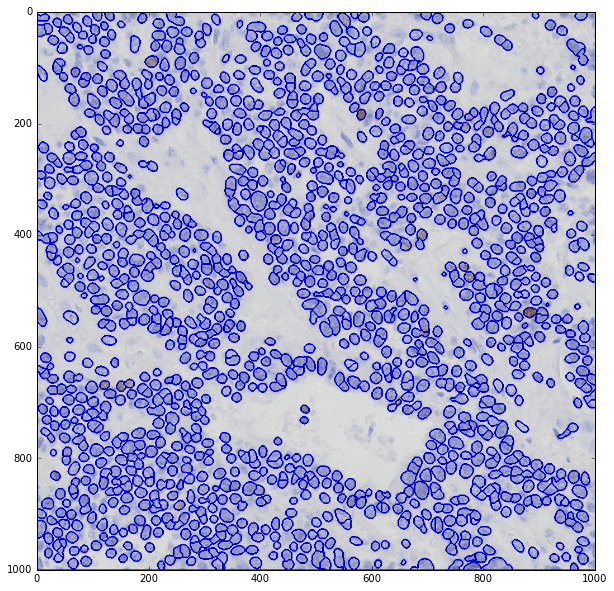

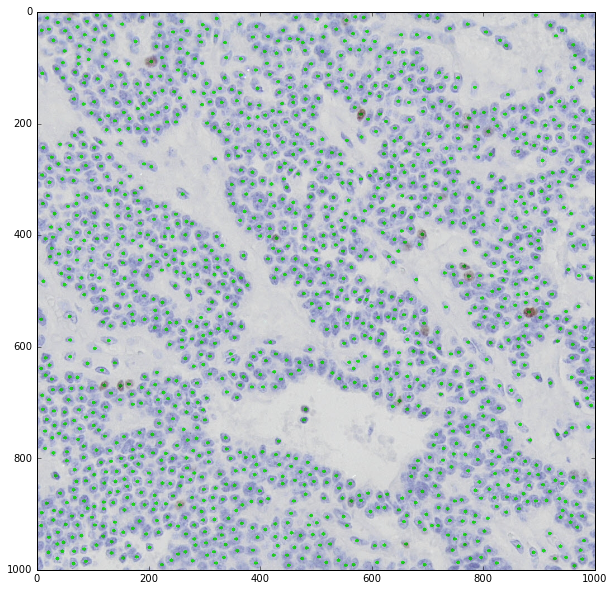

In [95]:
def seg_fn(seg_prob, coordinates, thresh = 0.5):
    marker_map = np.zeros_like(seg_prob).astype(np.uint8)
    marker_map[coordinates[:, 0], coordinates[:, 1]] = 1
    #imshow(marker_map)
    #se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    #marker_map = cv2.dilate(marker_map,se)
    
    #label_img = overal_cell_watershed(seg_prob, marker_map, thresh = thresh)
    imshow(seg_prob)
    imshow(marker_map)
    label_img = overal_watershed_marker(seg_prob, marker_map)
    return label_img

seg_label = seg_fn(seg_map, coordinates)

#imshow(seg_label)
#imshow(label2rgb(seg_label,img, alpha=0.3),(10,10))

contourMarkeredImg = label2contour(img, seg_label, linewidth=3)

imshow( contourMarkeredImg, (10,10))
imshow( det_masked, (10,10))


In [ ]:

seg_label = seg_fn(seg_map, coordinates)

print seg_label.shape
print img.shape
#imshow(seg_label)
imshow(label2rgb(seg_label,img, alpha=0.3),(10,10))

contourMarkeredImg = label2contour(img, seg_label)

imshow( contourMarkeredImg, (10,10))

In [93]:
import cv2
import scipy
from   skimage.feature import peak_local_max
from   skimage import data

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label
from skimage.morphology import closing, square
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage import io
from local_utils import *
import numpy as np

from skimage import measure

from skimage.filters import frangi

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max
import skimage

import numpy as np
from skimage.morphology import square



def imdilate(img, size):
    img = skimage.morphology.dilation(img, square(size))
    return img

def overal_watershed_marker(probmap,marker, thresh_water = 0.6, thresh_seg = 0.5,ratio = 0.2, dist_f = np.median):

    npad2 = ((1,1),(1,1))
    probmap = np.pad(probmap, npad2, mode='constant', constant_values=0)
    marker = np.pad(marker, npad2, mode='constant', constant_values=0)
    
    
    ret, fg_mask = cv2.threshold(probmap.astype(np.float32),0.7,255,0)
    #ret, seed_mask = cv2.threshold(probmap.astype(np.float32),0.7,255,0)
    
    
    marker[fg_mask == 0] = 0
    
    ret, markers = cv2.connectedComponents(marker)
    #markers = skimage.morphology.label(marker)
    
    #markers = markers.astype(markers_.dtype)
    #imshow(markers > 1)
    
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
    fg_mask = cv2.dilate(fg_mask,se)
    
    fg_mask_color = cv2.cvtColor(fg_mask.astype('uint8'),cv2.COLOR_GRAY2RGB)
    imshow(fg_mask_color)
    markers = cv2.watershed(fg_mask_color, markers)
    

    remove_boarder_marker = markers[1:-1, 1:-1]
    return remove_boarder_marker



In [ ]:


#=================
from skimage.feature import peak_local_max
from scipy.ndimage.morphology import distance_transform_edt
from plot_color_mask import overlay_mask
morph_kernel = np.ones((3,3),np.uint8)
# distance transform first
center_mask = center_out > 0.5
center_mask = cv2.dilate(center_mask.astype('uint8'), morph_kernel,iterations=1)
dist = cv2.distanceTransform(center_mask,cv2.DIST_L2,5)

centers = peak_local_max(dist, min_distance=15)
marker_mask = np.zeros_like(center_mask)
marker_mask[centers[:,0], centers[:,1]] = 1
ret, markers = cv2.connectedComponents(marker_mask)


ret, fg_mask = cv2.threshold(fg_out,0.4,255,0)
plt.figure()
plt.imshow(fg_mask)
print fg_mask.max(), fg_mask.min()
fg_mask_color = cv2.cvtColor(fg_mask.astype('uint8'),cv2.COLOR_GRAY2RGB)
markers = cv2.watershed(fg_mask_color, markers)
markers[fg_mask == 0] = 0
print markers.shape, np.unique(markers)
overlay_img = overlay_mask(np.uint8(im), markers)
plt.figure()
plt.imshow(markers)

plot_centers(center_out, centers, 42)
plot_centers(im, centers, 42)